# Content <-> audience

In [27]:
import pandas as pd
import warnings

from itertools import product
from tqdm import tqdm

from scipy import stats

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [29]:
warnings.simplefilter('ignore')

In [30]:
dfc = pd.read_json('data/hl-graph.json', lines=True)

In [31]:
dfa = pd.read_json('data/user-graph.json', lines=True)

In [32]:
DOMAINS = dfc.d1.unique()

In [33]:
C_METRICS = sorted(set(dfc.columns) - {'d1', 'd2'})

In [34]:
A_METRICS = sorted(set(dfa.columns) - {'d1', 'd2'})

In [9]:
def plot_domain_content(domain, title=None, dst=None):
    
    pdf = dfc[dfc.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], C_METRICS)
    
    plt.figure(figsize=(5,10), dpi=100)
    
    if title:
        plt.title(title)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')
    
    plt.show()

In [10]:
def plot_domain_audience(domain, title=None, dst=None):
    
    pdf = dfa[dfa.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], A_METRICS)

    plt.figure(figsize=(5,10), dpi=100)
    
    if title:
        plt.title(title)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')

    plt.show()

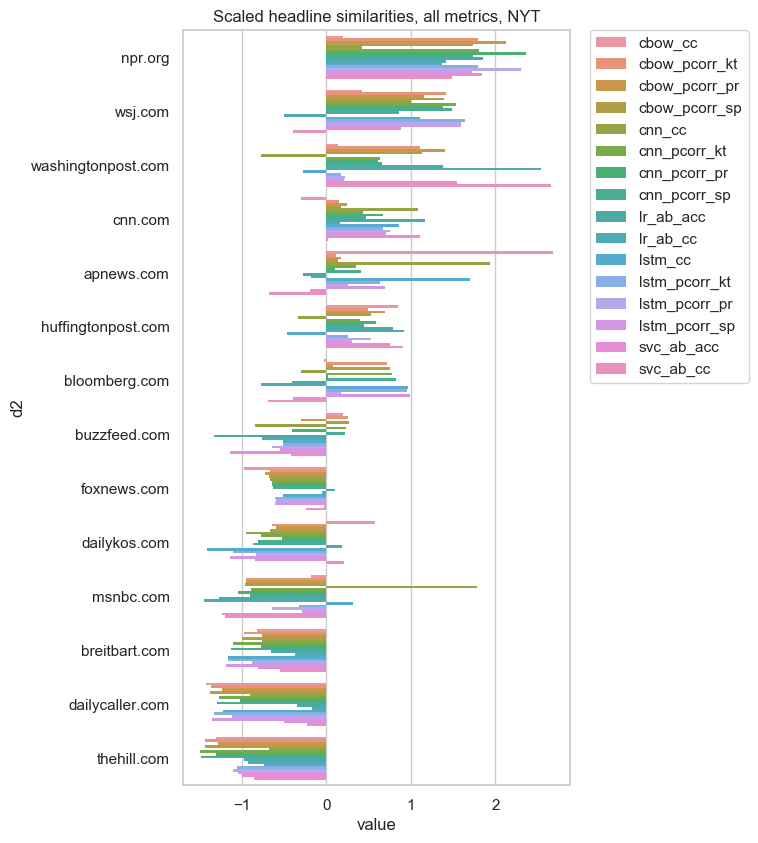

In [11]:
plot_domain_content('nytimes.com', 'Scaled headline similarities, all metrics, NYT', 'figures/ca-nyt-content.png')

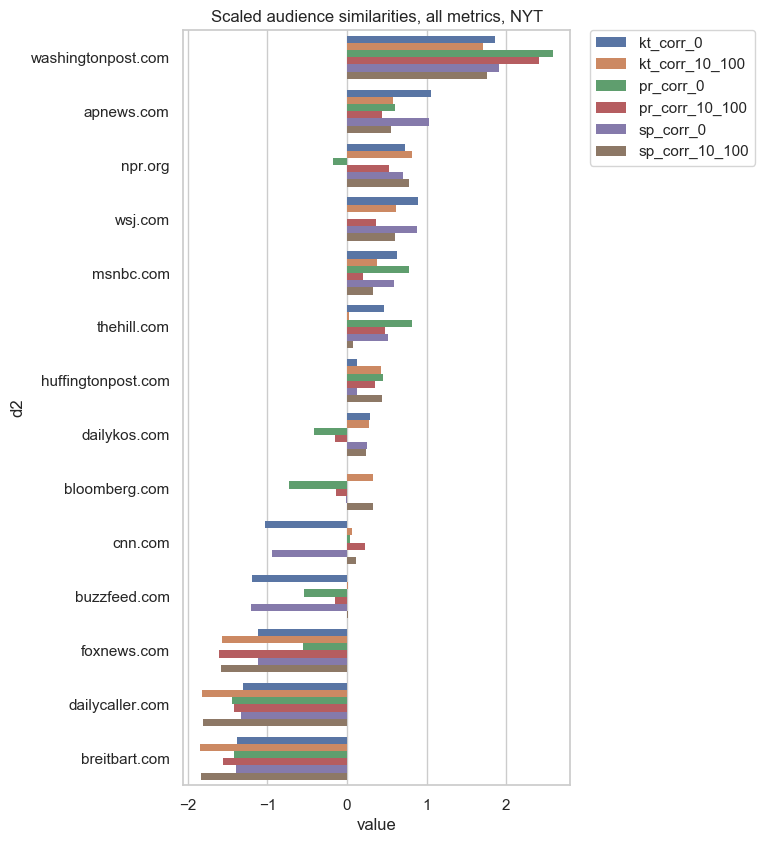

In [12]:
plot_domain_audience('nytimes.com', 'Scaled audience similarities, all metrics, NYT', 'figures/ca-nyt-audience.png')

In [13]:
def ca_corr(domain, c_metric, a_metric, plot=False):
    
    ddfc = dfc[dfc.d1==domain][['d2', c_metric]]
    ddfa = dfa[dfa.d1==domain][['d2', a_metric]]
    
    ddf = ddfc.merge(ddfa)
    
    if plot:
        ddf_melt = ddf.melt('d2', [c_metric, a_metric])
        order = ddf.sort_values(c_metric, ascending=False).d2
        plt.figure(figsize=(4,5))
        sns.barplot(y='d2', x='value', hue='variable', data=ddf_melt, order=order)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    return stats.pearsonr(ddf[c_metric], ddf[a_metric])

In [14]:
rows = []
for d, cm, am in tqdm(product(DOMAINS, C_METRICS, A_METRICS)):
    corr, p = ca_corr(d, cm, am)
    rows.append((d, cm, am, corr, p))

1440it [00:05, 251.00it/s]


In [15]:
corr_df = pd.DataFrame(rows, columns=('domain', 'cm', 'am', 'corr', 'p'))

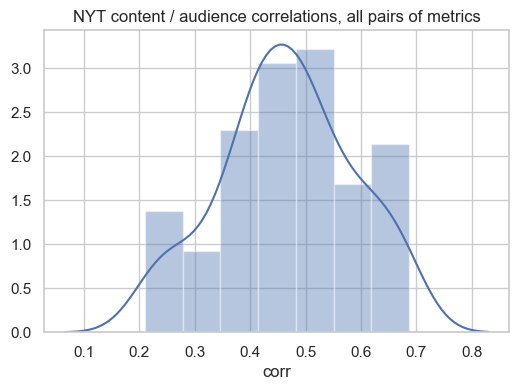

In [16]:
plt.figure(figsize=(6,4), dpi=100)
plt.title('NYT content / audience correlations, all pairs of metrics')
sns.distplot(corr_df[corr_df.domain=='nytimes.com']['corr'])
plt.savefig('figures/nyt-corr-dist.png', bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

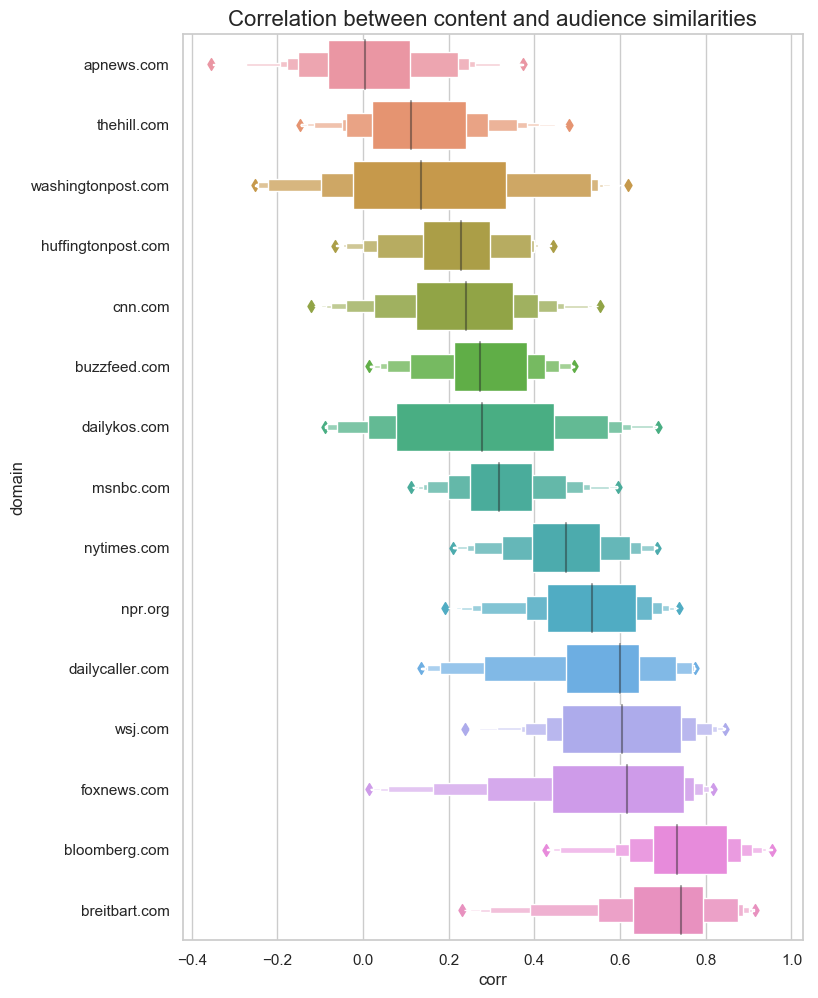

In [17]:
order = corr_df.groupby('domain').median().sort_values('corr').index
plt.figure(figsize=(8,12), dpi=100)
plt.title('Correlation between content and audience similarities', fontsize=16)
sns.boxenplot(x='corr', y='domain', data=corr_df, order=order)
plt.savefig('figures/ca-corr.png', bbox_inches='tight')

In [18]:
def plot_ac(domain, dst):
    
    ddfc = dfc[dfc.d1==domain]
    ddfa = dfa[dfa.d1==domain]
    ddf = ddfc.merge(ddfa)
    
    pdf = ddf.melt(['d2'], C_METRICS+A_METRICS)
    pdf['metric_type'] = pdf['variable'].apply(lambda x: 'content' if x in C_METRICS else 'audience')
    
    order = pdf[pdf.metric_type=='content'].groupby('d2').mean().sort_values('value', ascending=False).index
    
    plt.figure(figsize=(5,5), dpi=100)
    plt.title(domain)
    sns.barplot(y='d2', x='value', hue='metric_type', data=pdf, order=order)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.savefig(dst, bbox_inches='tight')
    
    plt.show()

apnews.com


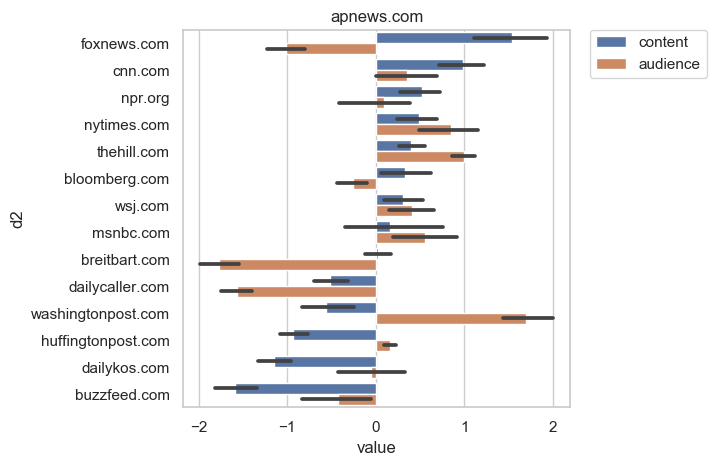

thehill.com


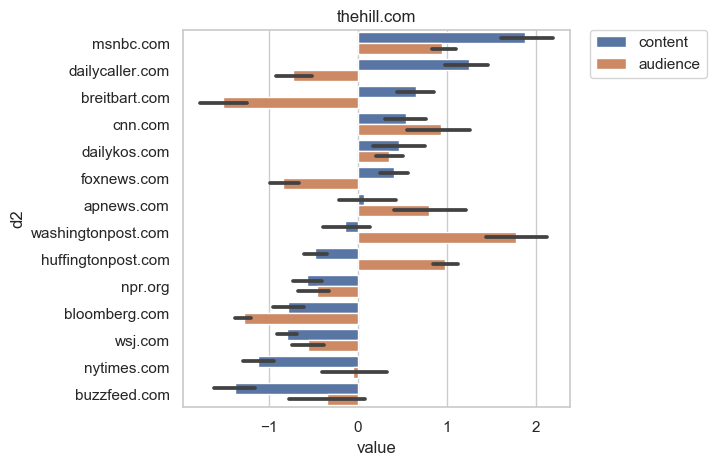

washingtonpost.com


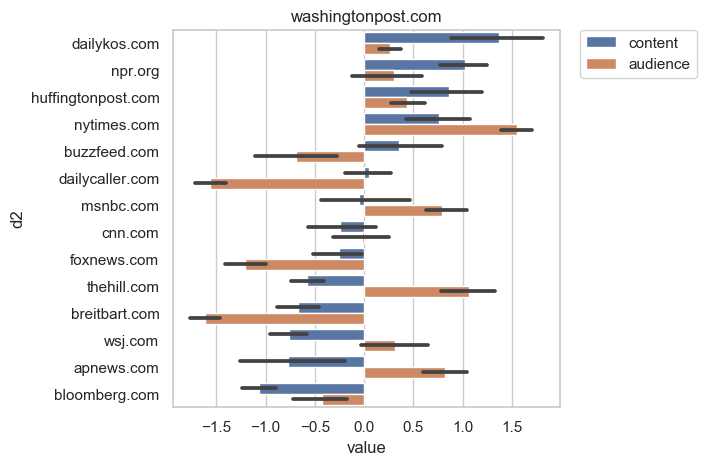

huffingtonpost.com


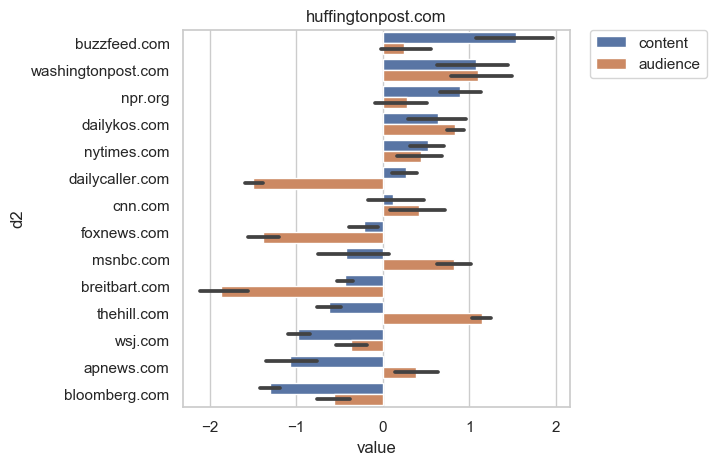

cnn.com


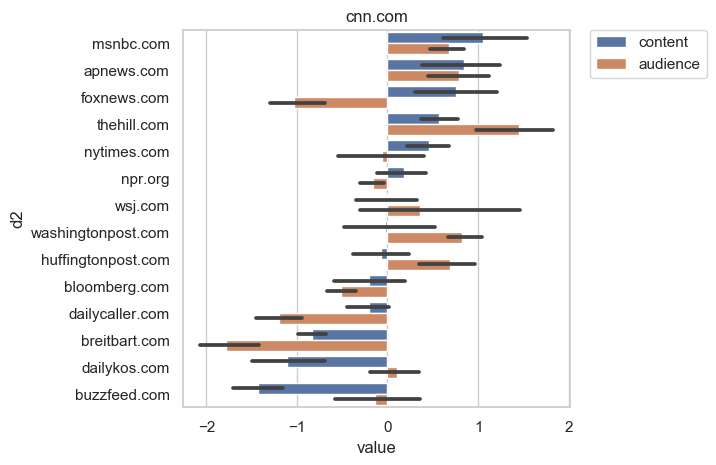

buzzfeed.com


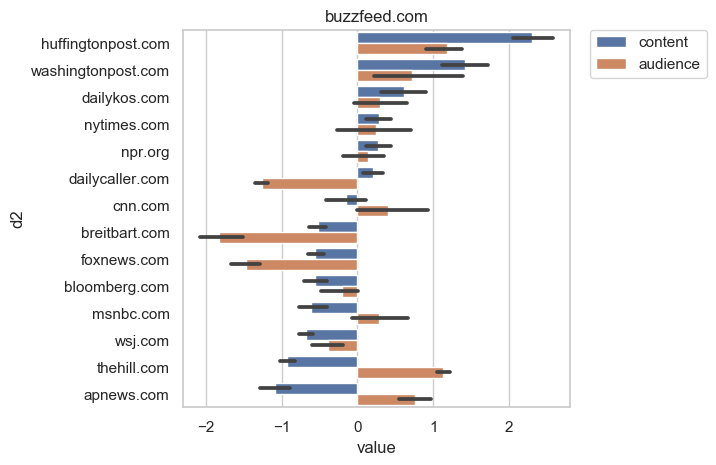

dailykos.com


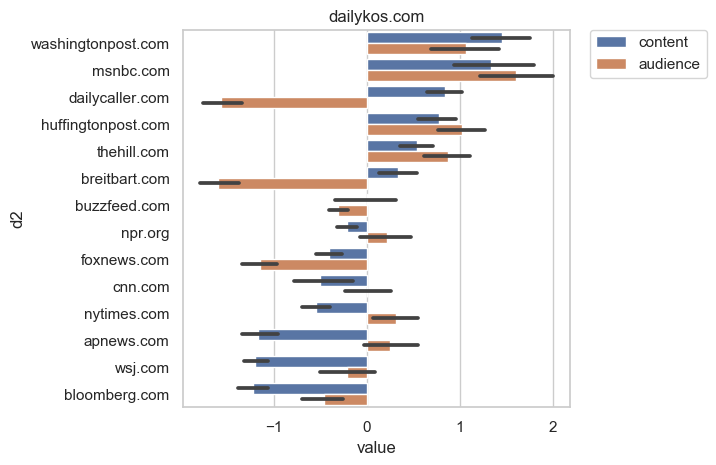

msnbc.com


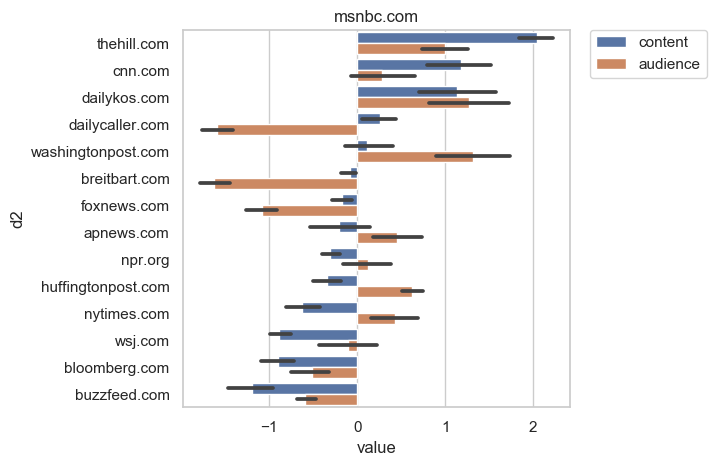

nytimes.com


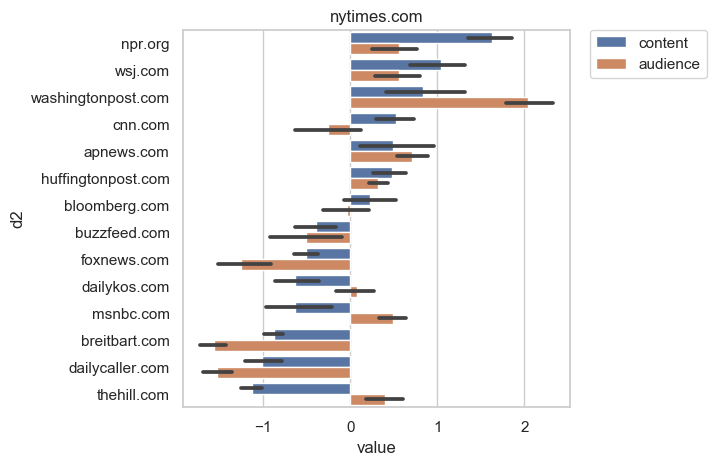

npr.org


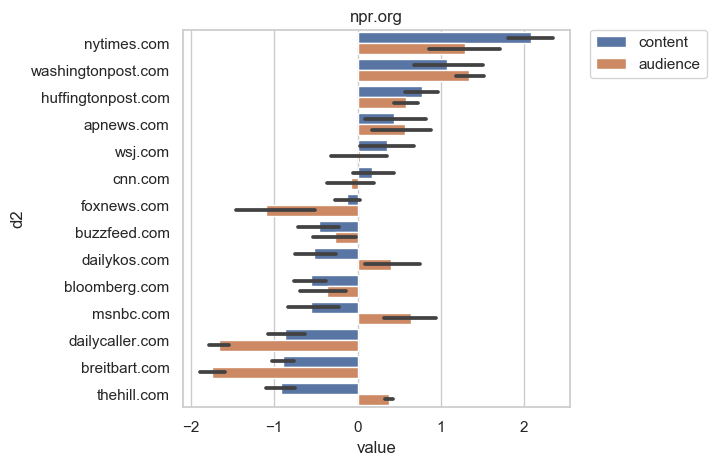

dailycaller.com


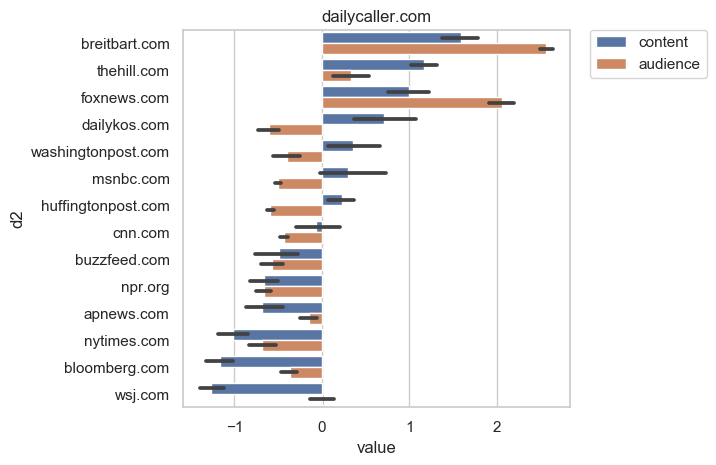

wsj.com


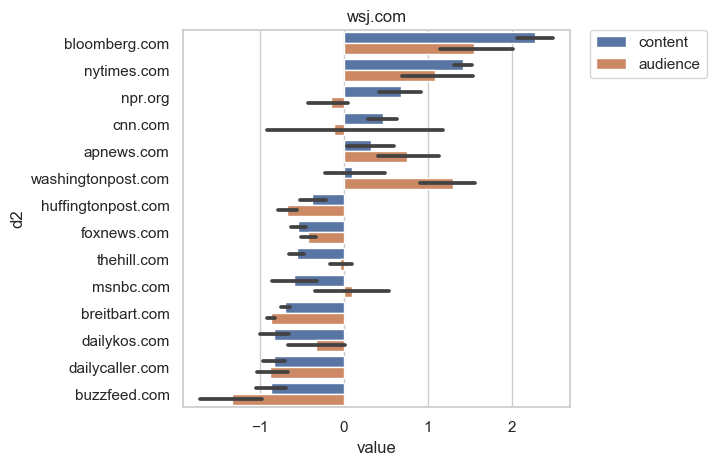

foxnews.com


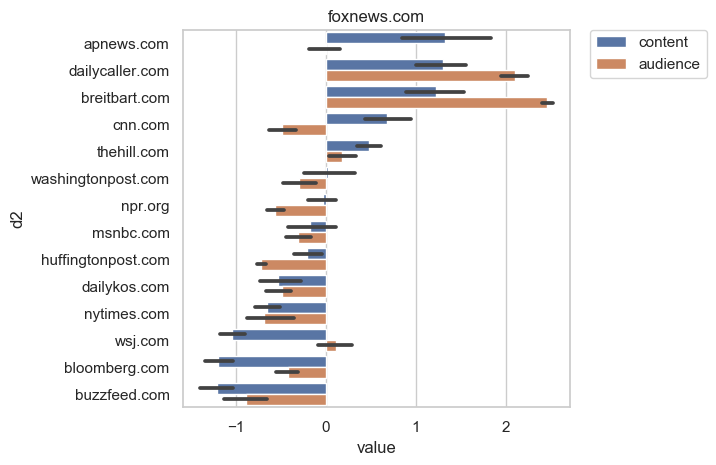

bloomberg.com


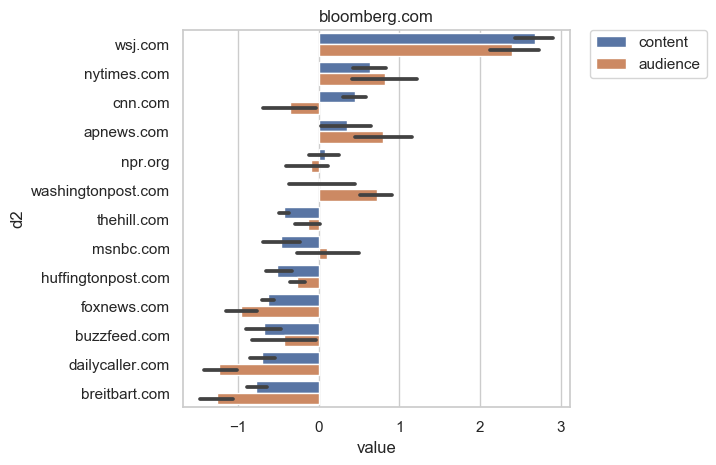

breitbart.com


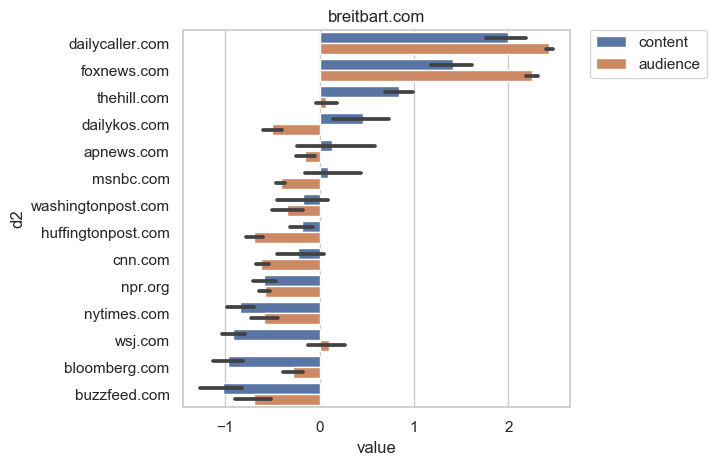

In [19]:
for d in order:
    print(d)
    slug = d.split('.')[0]
    plot_ac(d, f'figures/ca-{slug}-composite.')

In [35]:
len(dfc)

210

In [36]:
len(dfa)

210

In [38]:
dfc.merge(dfa).head(10)

,cbow_cc,cbow_pcorr_kt,cbow_pcorr_pr,cbow_pcorr_sp,cnn_cc,cnn_pcorr_kt,cnn_pcorr_pr,cnn_pcorr_sp,d1,d2,...,lstm_pcorr_pr,lstm_pcorr_sp,svc_ab_acc,svc_ab_cc,kt_corr_0,kt_corr_10_100,pr_corr_0,pr_corr_10_100,sp_corr_0,sp_corr_10_100
0,-0.869252,-1.218550,-0.933927,-1.243301,-0.501041,-1.288712,-0.913816,-1.311876,dailycaller.com,bloomberg.com,...,-1.012177,-1.263963,-1.594392,-1.364041,-0.418615,-0.235411,-0.532111,-0.362259,-0.429660,-0.220546
1,1.592446,1.814406,2.068860,1.750637,0.692218,1.677286,1.859997,1.608844,dailycaller.com,breitbart.com,...,2.074253,1.735929,1.413211,1.131873,2.612791,2.549395,2.726411,2.438981,2.588784,2.497183
2,1.870380,0.835235,0.531853,0.864149,-0.924815,1.037955,0.466944,1.049323,dailycaller.com,dailykos.com,...,0.309841,0.955215,-0.080488,1.678830,-0.805899,-0.512047,-0.601993,-0.409273,-0.830942,-0.478788
3,-0.452351,0.051235,-0.053930,0.058726,-0.757536,0.367095,0.424746,0.381992,dailycaller.com,washingtonpost.com,...,0.442834,0.370661,0.671584,1.587591,-0.195303,-0.606943,-0.239537,-0.546237,-0.171133,-0.651246
4,-1.306005,-1.453551,-1.145166,-1.474492,-0.556801,-1.670325,-1.406704,-1.677374,dailycaller.com,wsj.com,...,-1.123131,-1.308661,-0.982431,-1.313439,0.161342,0.110523,-0.382385,-0.043898,0.153879,0.126894
5,0.441007,1.146214,1.558715,1.148496,-0.244546,1.114991,1.440319,1.112033,dailycaller.com,foxnews.com,...,1.477398,1.147020,1.418348,0.529720,1.820420,2.116003,2.081742,2.365287,1.825133,2.141707
6,-0.075156,0.129218,0.024382,0.147421,-0.211091,0.366662,0.499022,0.389757,dailycaller.com,huffingtonpost.com,...,0.305297,0.327442,0.572162,0.346973,-0.593831,-0.643569,-0.486827,-0.596601,-0.600206,-0.648419
7,0.937317,0.489329,0.037809,0.521487,2.956064,0.243369,-0.179346,0.287227,dailycaller.com,msnbc.com,...,-0.362733,0.162929,-0.467387,-0.250884,-0.557791,-0.477263,-0.493334,-0.444636,-0.581334,-0.447710
8,0.063811,-0.510991,-0.697683,-0.505148,0.569546,-0.803029,-0.896982,-0.813751,dailycaller.com,apnews.com,...,-0.878268,-1.027898,-0.768776,-1.211340,0.024212,-0.203208,-0.292014,-0.263519,0.012624,-0.188241
9,1.016727,1.311180,1.313192,1.313968,0.926409,1.146511,1.368978,1.160622,dailycaller.com,thehill.com,...,1.342265,1.280582,0.892237,0.819877,0.630952,0.290609,-0.012515,0.061578,0.671590,0.332793
